In [1]:
import geopandas as gpd, pandas as pd, rasterio as rio, os, numpy as np
from rasterio.transform import from_origin
from rasterio.features import rasterize
from rasterio.mask import mask

## Select area borders

In [2]:
# select only the study area (Bologna province)
read_province_borders = gpd.read_file("Limiti01012023/ProvCM01012023/ProvCM01012023_WGS84.shp")
bologna_borders = read_province_borders[read_province_borders['COD_PROV'] == 37].reset_index(drop=True)

<Axes: >

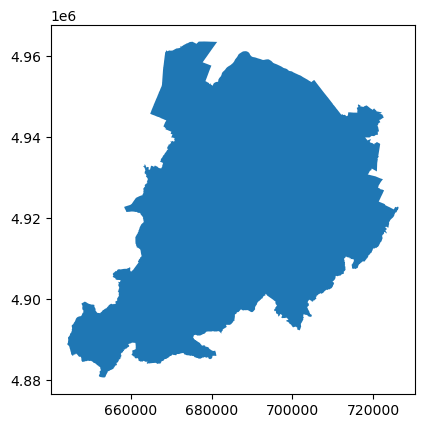

In [3]:
bologna_borders.plot()

## Load DEM data

In [4]:
# Carica il raster
raster_path = 'DEM/Emilia-Romagna1.tif'

raster = rio.open(raster_path)

# Estrai le geometrie dal GeoDataFrame
geometries = bologna_borders.geometry.values

# Applica la maschera al raster
out_image, out_transform = mask(raster, geometries, crop=True)

# Metadati per il raster risultante
out_meta = raster.meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# Salva il raster risultante
output_raster_path = 'restricted_analysis/DEM_Bologna.tif'
with rio.open(output_raster_path, 'w', **out_meta) as dest:
    dest.write(out_image)

## Load IGM Data

In [5]:
shp_folder_path = 'IGM_Data/shp_extracted'
output_folder_path = 'restricted_analysis/IGM_data_clip'

for filename in os.listdir(shp_folder_path):
    if filename.endswith('.shp'):
        shp_path = os.path.join(shp_folder_path, filename)

        # Verifica se il file .shp già esiste nell'output folder
        output_filename = f'clipped_{filename}'
        output_path = os.path.join(output_folder_path, output_filename)
        if os.path.exists(output_path):
            print(f'Il file {output_filename} già esiste. Salto il processo.')
            continue

        gdf = gpd.read_file(shp_path)

        # Assicurati che i CRS corrispondano
        if gdf.crs != bologna_borders.crs:
            bologna_borders = bologna_borders.to_crs(gdf.crs)

        # Intersezione con la maschera
        clipped_gdf = gpd.overlay(gdf, bologna_borders, how='intersection')

        # Riassegna il CRS prima di salvare, se necessario
        if not clipped_gdf.empty:
            clipped_gdf.set_crs(bologna_borders.crs, inplace=True)
            clipped_gdf.to_file(output_path)
            print(f'File {output_filename} salvato con successo.')
        else:
            print(f'Nessuna intersezione trovata per {filename}')

Il file clipped_argine.shp già esiste. Salto il processo.
Il file clipped_condot.shp già esiste. Salto il processo.
Il file clipped_op_por.shp già esiste. Salto il processo.
Il file clipped_ps_inc.shp già esiste. Salto il processo.
Il file clipped_sv_str.shp già esiste. Salto il processo.
Il file clipped_ar_vrd.shp già esiste. Salto il processo.
Nessuna intersezione trovata per ar_mar.shp
Nessuna intersezione trovata per mu_sos.shp
Il file clipped_bosco.shp già esiste. Salto il processo.
Il file clipped_scarpt.shp già esiste. Salto il processo.
Nessuna intersezione trovata per pt_btm.shp
Nessuna intersezione trovata per gz_met.shp
Nessuna intersezione trovata per el_acq.shp
Il file clipped_cv_aes.shp già esiste. Salto il processo.
Il file clipped_edi_min.shp già esiste. Salto il processo.
Il file clipped_cl_agr.shp già esiste. Salto il processo.
Il file clipped_el_idr.shp già esiste. Salto il processo.
Il file clipped_provin.shp già esiste. Salto il processo.
Il file clipped_cv_dis.shp

### Load buildings data

In [6]:
bologna_buildings = gpd.read_file('restricted_analysis/IGM_data_clip/clipped_edifc.shp')

In [7]:

# Dizionario completo per la mappatura dei codici
uso_to_descrizione = {
    '01': 'residenziale',
    '0101': 'abitativa',
    '02': 'amministrativo',
    '0201': 'municipio',
    '0202': 'sede provincia',
    '0203': 'sede regione',
    '0204': 'sede ambasciata o consolato',
    '03': 'servizio pubblico',
    '0301': 'sanità',
    '030101': 'sede di servizio socio assistenziale',
    '030102': 'sede di ospedale',
    '030103': 'sede servizi sanitari asl',
    '030104': 'sede clinica',
    '0303': 'istruzione',
    '030301': 'sede di scuola',
    '030302': 'università',
    '030303': 'laboratorio di ricerca',
    '0304': 'sede di poste-telegrafi',
    '0305': 'sede di tribunale',
    '0306': "sede di forze dell'ordine",
    '0307': 'sede di vigili del fuoco',
    '0308': 'casello forestale',
    '04': 'militare',
    '0401': 'caserma',
    '05': 'luogo di culto',
    '06': 'servizi di trasporto',
    '0601': 'aereo',
    '060101': 'stazione passeggeri aeroportuale',
    '060102': 'eliporto',
    '0602': 'stradale',
    '060201': 'stazione autolinee',
    '060202': 'parcheggio multipiano o coperto',
    '060203': 'edificio accessorio alle strade',
    '0603': 'ferroviario',
    '060301': 'stazione passeggeri ferroviaria',
    '060302': 'deposito ferroviario per vagoni, rimessa locomotive',
    '060303': 'casello ferroviario',
    '060304': 'fermata ferroviaria',
    '060305': 'scalo merci',
    '0604': 'altro impianto di trasporto',
    '060401': 'stazione marittima',
    '060402': 'stazione metropolitana',
    '060403': 'stazione tranviaria',
    '060404': 'stazione funivia',
    '060405': 'stazione cabinovia',
    '060406': 'stazione seggiovia',
    '060407': 'stazione skilift',
    '07': 'commerciale',
    '0701': 'sede di banca',
    '0702': 'sede di centro commerciale',
    '0703': 'mercato',
    '0704': 'sede di supermercato, ipermercato',
    '08': 'industriale',
    '0801': 'stabilimento industriale',
    '0802': 'impianto di produzione energia',
    '080201': 'centrale elettrica',
    '080202': 'centrale termoelettrica',
    '080203': 'centrale idroelettrica',
    '080204': 'centrale nucleare',
    '080206': 'stazione di trasformazione',
    '0803': 'impianto tecnologico',
    '0804': 'depuratore',
    '0805': 'inceneritore',
    '0806': 'stazione di telecomunicazioni',
    '0807': 'edificio di teleriscaldamento',
    '0808': 'edificio di area ecologica',
    '09': 'agricolturale',
    '0901': 'fattoria',
    '0902': 'stalla',
    '0903': 'fienile',
    '0904': 'allevamento',
    '10': 'ricreativo',
    '1001': 'sede di attività culturali',
    '100101': 'biblioteca',
    '100102': 'cinema',
    '100103': 'teatro, auditorium',
    '100104': 'museo',
    '100105': 'pinacoteca',
    '1002': 'sede di attività sportive',
    '100201': 'piscina coperta',
    '100202': 'palestra',
    '100203': 'palaghiaccio',
    '11': 'carcere, istituto di pena',
    '12': 'strutture ricettive',
    '1201': 'struttura alberghiera',
    '1202': 'sede albergo, locanda',
    '1203': 'campeggio',
    '1204': 'rifugio montano',
    '93': 'non definito',
    '95': 'altro'
}

# Creare una nuova colonna nel DataFrame
bologna_buildings['categoria_uso'] = bologna_buildings['edifc_uso'].map(uso_to_descrizione)

In [45]:
residential_buildings = bologna_buildings[bologna_buildings['edifc_uso'].isin(['01', '0101'])].reset_index(drop=True)

In [46]:
# Crea un buffer di 100 metri
buffered_buildings = residential_buildings.buffer(100)

# Crea un nuovo GeoDataFrame
gdf_buffered = gpd.GeoDataFrame(geometry=buffered_buildings)

# Dissolvi tutte le geometrie in una unica
dissolved_geometry = gdf_buffered.unary_union

# Se vuoi creare un GeoDataFrame con la geometria dissolta
dissolved_buffer_buildings = gpd.GeoDataFrame(geometry=[dissolved_geometry], crs=gdf_buffered.crs)

In [47]:
#dissolved_buffer_buildings.to_file('dissolved_buffer_buildings.shp')

In [53]:
# Carica il raster TIFF esistente
with rio.open("restricted_analysis/DEM_Bologna.tif") as src:
    bounds = src.bounds
    pixel_size_x, pixel_size_y = src.res
    width = src.width
    height = src.height
    transform = src.transform
    crs = src.crs

# Assumi che 'dissolved_buffer_buildings' sia il tuo GeoDataFrame
geometry = dissolved_buffer_buildings.to_crs(crs).geometry[0]

# Funzione per ottenere il valore da rasterizzare (in questo caso 1 per la geometria, 0 altrimenti)
def get_val(geom):
    return 1

# Crea un array vuoto per il raster
raster = np.zeros((height, width), dtype=np.float32)

# Rasterizza la geometria
rasterized_geom = rasterize(
    [(geometry, get_val(geometry))],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    all_touched=True,
    default_value=1,
    dtype='float32'
)

# Salva il raster risultante
output_raster_file = 'restricted_analysis/bologna_sound_distance_respect_norm.tif'
with rio.open(
    output_raster_file, 'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=rasterized_geom.dtype,
    crs=crs,
    transform=transform,
) as dst:
    dst.write(rasterized_geom, 1)

## Load Census data

In [52]:
# Carica i dati del censimento
emilia_census_data = pd.read_csv('Census_data/2021_provisional/Dati_regionali_2021/R08_indicatori_2021_sezioni.csv',
                                 encoding='latin-1', sep=';')

# Carica i dati geografici
gdf_census = gpd.read_file('Census_data/2011/R08_11_WGS84/R08_11_WGS84.shp')

# Esegui il join tra DataFrame e GeoDataFrame sulla colonna comune
gdf = gdf_census.merge(emilia_census_data, on='SEZ2011', how='left')

# Sostituisci i valori NaN con 0 e converti in int, se necessario
for col in gdf.columns:
    if gdf[col].dtype == int or gdf[col].dtype == float:
        gdf[col] = gdf[col].fillna(0).astype(int)

# Calcola l'area in metri quadrati e in chilometri quadrati
gdf['area_m2'] = gdf.to_crs({'init': 'epsg:3857'}).area
gdf['area_km2'] = gdf['area_m2'] / 1e6

# Calcola la densità di popolazione originale in persone per km^2 e m^2
gdf['pop_density_km2'] = gdf['P1'] / gdf['area_km2']
gdf['pop_density_m2'] = gdf['P1'] / gdf['area_m2']

C:\Users\niett\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1538: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1538: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

In [25]:
# Nome del file di output
output_file = 'restricted_analysis/census_data_bologna.shp'

# Verifica se il file esiste
if os.path.exists(output_file):
    # Carica direttamente il file se esiste
    clipped_gdf = gpd.read_file(output_file)
else:
    # Assicurati che i CRS corrispondano
    if gdf.crs != bologna_borders.crs:
        print("I due CRS sono diversi")
        bologna_borders = bologna_borders.to_crs(gdf.crs)

    # Effettua il clip
    clipped_gdf = gpd.clip(gdf, bologna_borders)

    # Salva il risultato solo se il file non esiste
    clipped_gdf.to_file(output_file, crs=gdf.crs)

C:\Users\niett\AppData\Local\Temp\ipykernel_17608\48183989.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_gdf.to_file(output_file, crs=gdf.crs)


### Prova raster to shp

In [32]:
# Apri il raster di riferimento per ottenere i dettagli sulla griglia
with rio.open("restricted_analysis/DEM_Bologna.tif") as src:
    bounds = src.bounds
    pixel_size_x, pixel_size_y = src.res  # Risoluzione in x e y
    width = src.width
    height = src.height
    transform = rio.transform.from_bounds(*bounds, width, height)

# Calcola la densità adattata alla risoluzione del raster (in persone per cella)
clipped_gdf['adjusted_density'] = clipped_gdf['pop_density_km2'] * (pixel_size_x * pixel_size_y / 1e6)

# Funzione per ottenere il valore da rasterizzare (senza ulteriori calcoli)
def get_val(geom, val):
    return val  # Usa direttamente il valore adattato

# Crea un array vuoto per il raster
raster = np.zeros((height, width), dtype=np.float32)

# Rasterizza per la densità della popolazione
rasterized_pop_density = rasterize(
    ((row.geometry, get_val(row.geometry, row['adjusted_density'])) for idx, row in clipped_gdf.iterrows()),
    out=raster,
    transform=transform,
    fill=0,
    all_touched=True,
    dtype='float32'
)

# Salva il raster della densità della popolazione
output_raster_file = 'restricted_analysis/pop_density_by_pixel.tif'
with rio.open(
    output_raster_file, 'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs=src.crs,
    transform=transform,
) as dst:
    dst.write(rasterized_pop_density, 1)

In [33]:
def mask_raster_with_geodataframe(raster_path, gdf, output_path):
    # Carica il raster
    with rio.open(raster_path) as src:
        # Converti le geometrie del GeoDataFrame in formati accettati da rio
        geometries = [feature["geometry"] for _, feature in gdf.iterrows()]
        out_image, out_transform = mask(src, geometries, crop=True)

        # Salva il raster mascherato
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})

        with rio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)

In [34]:
# Esempio di utilizzo
mask_raster_with_geodataframe('restricted_analysis/pop_density_by_pixel.tif', bologna_borders, 'restricted_analysis/pop_density_by_pixel_masked.tif')

#### Manca un pezzo di codice per ottenere la kernel density (troppo lento con il codice fatto)

## Load D-flight Data

In [6]:
d_flight_areas = gpd.read_file('D-flight data/D_flight_clean.shp')

<Axes: >

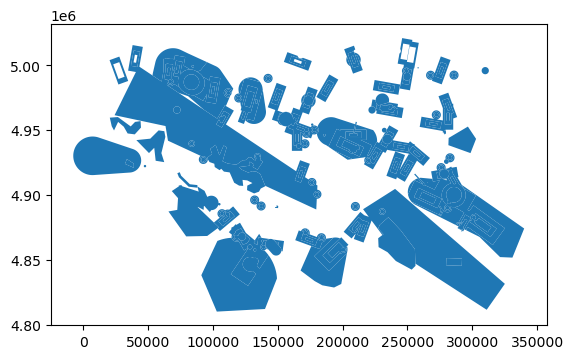

In [7]:
d_flight_areas.plot()

In [8]:
result_file_path = 'restricted_analysis/d_flight_bologna_clip.shp'

# Verifica se il file risultante già esiste
if os.path.exists(result_file_path):
    # Se esiste, carica il GeoDataFrame dal file
    d_flight_bologna = gpd.read_file(result_file_path)
else:
    # Se non esiste, esegui il clip come prima
    if d_flight_areas.crs != bologna_borders.crs:
        d_flight_areas = d_flight_areas.to_crs(bologna_borders.crs)

    clip_geometry = bologna_borders.unary_union
    d_flight_bologna = gpd.clip(d_flight_areas, clip_geometry)

    # Salva il risultato in un file
    d_flight_bologna.to_file(result_file_path)

<Axes: >

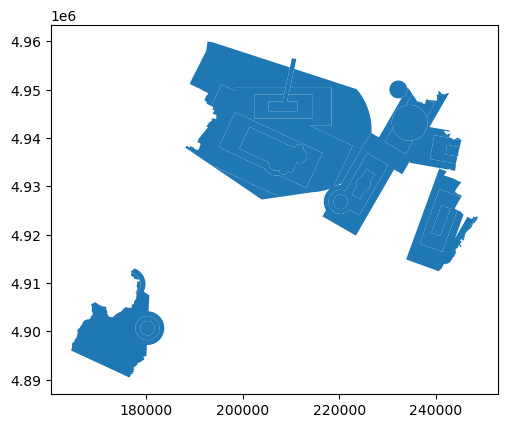

In [9]:
d_flight_bologna.plot()

In [24]:
# Leggi il raster DEM per ottenere l'estensione e la risoluzione desiderate
with rio.open('restricted_analysis/DEM_Bologna.tif') as src_dem:
    transform = src_dem.transform
    crs = src_dem.crs
    width = src_dem.width
    height = src_dem.height

# Riproietta il GeoDataFrame nel CRS del raster DEM
d_flight_bologna = d_flight_bologna.to_crs(crs)

# Crea una nuova directory se non esiste
output_directory = 'restricted_analysis'
os.makedirs(output_directory, exist_ok=True)

# Percorso del raster da creare
raster_path = os.path.join(output_directory, 'bologna_d_flight_data.tif')

# Crea un nuovo raster per contenere il GeoDataFrame convertito
with rio.open(
    raster_path,
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,  # Si assume un raster a banda singola
    dtype='float32',
    crs=crs,
    transform=transform,
) as dst:
    # Rasterizza il GeoDataFrame usando la stessa estensione e risoluzione del raster DEM
    shapes = [(geom, value) for geom, value in zip(d_flight_bologna.geometry, d_flight_bologna['quota_max'])]
    burned = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        fill=-9999,  # Valore di riempimento per le aree al di fuori dei poligoni
        transform=dst.transform,
        dtype='float32',
    )

    # Scrivi i dati rasterizzati nel raster di output
    dst.write(burned, 1)

# Leggi il raster originale
with rio.open(raster_path) as src:
    data = src.read(1)  # Leggi il primo canale
    profile = src.profile

    # Sostituisci -9999 con NaN
    data = np.where(data == -9999, np.nan, data)

# Calcola minimo e massimo ignorando NaN
min_val = np.nanmin(data)
max_val = np.nanmax(data)

# Controlla se minimo e massimo sono uguali
if max_val - min_val == 0:
    transformed_data = np.zeros(data.shape)
else:
    # Trasforma i dati (inversione), ignorando NaN
    transformed_data = (max_val - data) / (max_val - min_val)

# Riapplica il valore -9999 dove erano presenti i NaN
#transformed_data = np.where(np.isnan(data), -9999, transformed_data)

# Percorso del raster normalizzato
normalized_raster_path = os.path.join(output_directory, 'bologna_d_flight_data_normalized.tif')

# Salva il raster trasformato
with rio.open(normalized_raster_path, 'w', **profile) as dst:
    dst.write(transformed_data, 1)

### Meteo data

In [4]:
# Apri il raster da mascherare
with rio.open('Storico meteo/Raster_export/average_normalized_raster.tif') as src:
    out_image, out_transform = mask(src, bologna_borders.geometry, crop=True)
    out_meta = src.meta.copy()

    # Aggiorna la metadata con le nuove dimensioni
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    # Salva il raster risultante
    with rio.open('restricted_analysis/bologna_wind_average_normalized_raster.tif', 'w', **out_meta) as dest:
        dest.write(out_image)

### Protected area

In [7]:
# Carica il file shapefile
protected_areas_gdf = gpd.read_file("restricted_analysis/bologna_protected_areas.shp")

# Leggi le informazioni dalla griglia di riferimento .tif
with rio.open("restricted_analysis/DEM_Bologna.tif") as src:
    transform = src.transform
    out_shape = (src.height, src.width)
    meta = src.meta

# Preparazione dei dati per la rasterizzazione
shapes = ((geom, 1) for geom in protected_areas_gdf.geometry)

# Rasterizzazione
rasterized_areas = rasterize(
    shapes,
    out_shape=out_shape,
    transform=transform,
    fill=0,
    all_touched=True,
    dtype='float32'
)

# Aggiorna il metadata per la nuova matrice raster
meta.update(dtype=rio.float32, count=1, compress='lzw')

# Scrivi la matrice rasterizzata in un nuovo file .tif
with rio.open('restricted_analysis/protected_areas_norm.tif', 'w', **meta) as dst:
    dst.write(rasterized_areas, 1)

### Multi-criteria calculation

In [35]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import os

In [36]:
def average_rasters(image_files, output_file):
    # Determinare l'estensione massima
    extents = []
    for path in image_files:
        with rasterio.open(path) as src:
            extents.append(src.bounds)

    min_left = min(ext.left for ext in extents)
    min_bottom = min(ext.bottom for ext in extents)
    max_right = max(ext.right for ext in extents)
    max_top = max(ext.top for ext in extents)

    # Calcolare la trasformazione per l'estensione massima
    dst_transform, width, height = calculate_default_transform(
        rasterio.crs.CRS.from_epsg(4326), rasterio.crs.CRS.from_epsg(4326),
        max_right - min_left, max_top - min_bottom,
        left=min_left, bottom=min_bottom, right=max_right, top=max_top
    )

    # Creare un raster di base vuoto
    sum_raster = np.zeros((height, width), dtype=np.float32)
    count_matrix = np.zeros((height, width), dtype=np.float32)

    # Riportare e sommare i raster
    for path in image_files:
        with rasterio.open(path) as src:
            reprojected_raster = np.zeros((height, width), dtype=np.float32)
            reproject(
                source=rasterio.band(src, 1),
                destination=reprojected_raster,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=rasterio.crs.CRS.from_epsg(4326),
                resampling=Resampling.nearest
            )
            sum_raster += reprojected_raster
            count_matrix += (reprojected_raster != 0)

    # Calcolare la media
    average_raster = sum_raster / np.where(count_matrix == 0, 1, count_matrix)

    # Salvare il raster risultante
    first_raster = rasterio.open(image_files[0])
    out_meta = first_raster.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": height,
        "width": width,
        "transform": dst_transform
    })

    with rasterio.open(output_file, "w", **out_meta) as dest:
        dest.write(average_raster, 1)

In [37]:
# Uso della funzione
directory = './restricted_analysis'
image_files = [os.path.join(directory, file) for file in os.listdir(directory) if 'norm' in file and file.endswith('.tif')]
output_file = 'average_raster.tif'

average_rasters(image_files, output_file)

CRSError: The EPSG code is unknown. PROJ: proj_create_from_database: C:\Users\niett\anaconda3\Library\share\proj\proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.

## Balistic impact

### Rasterize buildings data

In [ ]:

%%time

buildings = gpd.read_file('Buildings_data/volumetria_edifici_uniti.shp')

In [ ]:
buildings = buildings.to_crs(bologna_borders.crs)

In [ ]:
clipped_buildings = gpd.overlay(buildings, bologna_borders, how='intersection')

In [ ]:
# Apri il raster di riferimento e crea un raster degli edifici
with rio.open("DEM/Emilia-Romagna1.tif") as src:
    transform = src.transform
    raster = np.zeros((src.height, src.width), dtype=np.float32)

    # Rasterizza gli edifici per l'altezza
    shapes = ((geom, value) for geom, value in zip(clipped_buildings.geometry, clipped_buildings['H_UVL']))
    rasterized_buildings = rasterize(shapes, out=raster, transform=transform, fill=0, all_touched=True, dtype='float32')

    # Definire i metadati per il nuovo raster
    raster_meta = src.meta.copy()
    raster_meta.update({
        'driver': 'GTiff',
        'height': rasterized_buildings.shape[0],
        'width': rasterized_buildings.shape[1],
        'count': 1,
        'dtype': rasterized_buildings.dtype
    })

    # Salvare il raster
    with rio.open('restricted_analysis/buildings_high_rasterize.tif', 'w', **raster_meta) as dst:
        dst.write(rasterized_buildings, 1)

### DEM + buildings raster

In [ ]:
def sum_rasters(raster1_path, raster2_path, output_path):
    # Apri il primo raster
    with rio.open(raster1_path) as src1:
        raster1 = src1.read(1)

        # Sostituisci i valori nodata con 0
        nodata1 = src1.nodata
        raster1[raster1 == nodata1] = 0

        # Apri il secondo raster
        with rio.open(raster2_path) as src2:
            # Assicurati che i raster abbiano le stesse dimensioni
            raster2 = src2.read(
                1,
                out_shape=(src1.height, src1.width),
                resampling=Resampling.nearest
            )

            # Sostituisci i valori nodata con 0 (se presente)
            nodata2 = src2.nodata
            if nodata2 is not None:
                raster2[raster2 == nodata2] = 0

            # Somma i raster
            result = raster1 + raster2

            # Salva il raster risultante
            profile = src1.profile
            with rio.open(output_path, 'w', **profile) as dst:
                dst.write(result, 1)


# Esempio di utilizzo
sum_rasters('restricted_analysis/DEM_Bologna.tif', 'restricted_analysis/buildings_high_rasterize.tif',
            'restricted_analysis/DEM_plus_buildings_raster_Bologna.tif')

### Balistic functions

In [ ]:
# Funzione per trasformare le coordinate geografiche in coordinate del raster
def transform_coordinates(x, y, raster):
    row, col = raster.index(x, y)
    return row, col

# Funzione per leggere i dati del vento dai raster
def get_wind_data(x, y, wind_speed_raster_path, wind_direction_raster_path):
    with rio.open(wind_speed_raster_path) as wind_speed_raster:
        wind_speed_row, wind_speed_col = transform_coordinates(x, y, wind_speed_raster)
        wind_speed = wind_speed_raster.read(1)[wind_speed_row, wind_speed_col]

    with rio.open(wind_direction_raster_path) as wind_direction_raster:
        wind_direction_row, wind_direction_col = transform_coordinates(x, y, wind_direction_raster)
        wind_direction = wind_direction_raster.read(1)[wind_direction_row, wind_direction_col]

    return wind_speed, wind_direction

# Funzione per calcolare la traiettoria e creare la matrice di distanze
def calcola_traiettoria_e_matrice(res, m, g, c, vxi, altitude_base, limite_distanza_verticale, wind_speed_x):
    def y_adjusted(t):
        return altitude_base - 0.5 * g * t ** 2

    def vx_wind(t, wind_speed_x, angle):
        wind_component = wind_speed_x * np.cos(np.radians(angle))
        return (vxi + wind_component) * np.exp(-c / m * t)

    time = 0
    x_total, y_total_adjusted = 0, altitude_base
    x_positions = []

    while y_total_adjusted > limite_distanza_verticale:
        angle = np.degrees(np.arctan2(y_total_adjusted - altitude_base, x_total)) if x_total != 0 else 90
        time += dt
        x_total += vx_wind(time, wind_speed_x, angle) * dt
        y_total_adjusted = y_adjusted(time)  # Correzione qui
        x_positions.append(x_total)

    max_distanza_orizzontale = max(x_positions)
    dimensione_matrice_orizzontale = int(np.ceil(max_distanza_orizzontale / res))
    dimensione_matrice = 2 * dimensione_matrice_orizzontale
    matrice_distanze = np.full((dimensione_matrice, dimensione_matrice), np.nan)

    centro = dimensione_matrice // 2
    epsilon = 1e-6

    for i in range(dimensione_matrice):
        for j in range(dimensione_matrice):
            dx = (i - centro) * res
            dy = (j - centro) * res
            distanza_orizzontale = np.sqrt(dx**2 + dy**2)
            angle = np.degrees(np.arctan2(dy, dx)) if distanza_orizzontale != 0 else 0

            if distanza_orizzontale <= max_distanza_orizzontale:
                velocità_orizzontale = max(vx_wind(0, wind_speed_x, angle), epsilon)
                t = distanza_orizzontale / velocità_orizzontale
                distanza_verticale = y_adjusted(t)
                matrice_distanze[i, j] = distanza_verticale

    return matrice_distanze, max_distanza_orizzontale

def bresenham_line(x0, y0, x1, y1):
    """Genera i punti lungo una linea retta da (x0, y0) a (x1, y1) usando l'algoritmo di Bresenham."""
    dx = x1 - x0
    dy = y1 - y0
    x, y = x0, y0

    ix = 1 if dx > 0 else -1
    iy = 1 if dy > 0 else -1
    dx = abs(dx)
    dy = abs(dy)

    if dx > dy:
        err = dx / 2.0
        while x != x1:
            yield x, y
            err -= dy
            if err < 0:
                y += iy
                err += dx
            x += ix
    else:
        err = dy / 2.0
        while y != y1:
            yield x, y
            err -= dx
            if err < 0:
                x += ix
                err += dy
            y += iy

    yield x1, y1

def aggiorna_visibilita_bresenham(matrice_binaria, centro_x, centro_y):
    altezza, larghezza = matrice_binaria.shape

    for y in range(altezza):
        for x in range(larghezza):
            visibile = True
            for punto_x, punto_y in bresenham_line(centro_x, centro_y, x, y):
                if 0 <= punto_y < altezza and 0 <= punto_x < larghezza:
                    if matrice_binaria[punto_y, punto_x] == 0:
                        visibile = False
                        break
                else:
                    break

            if not visibile:
                matrice_binaria[y, x] = 0

    return matrice_binaria

def calcola_sottrazione_e_matrice_binaria(dem_data, matrice_distanze, nodata, centro_x, centro_y):
    offset_x = centro_x - matrice_distanze.shape[1] // 2
    offset_y = centro_y - matrice_distanze.shape[0] // 2
    sottrazione_matrice = np.full(matrice_distanze.shape, np.nan)

    for i in range(matrice_distanze.shape[0]):
        for j in range(matrice_distanze.shape[1]):
            dem_x = j + offset_x
            dem_y = i + offset_y
            if 0 <= dem_x < dem_data.shape[1] and 0 <= dem_y < dem_data.shape[0]:
                if not np.isnan(matrice_distanze[i, j]):
                    valore_dem = dem_data[dem_y, dem_x] if dem_data[dem_y, dem_x] != nodata else 0
                    sottrazione_matrice[i, j] = valore_dem - matrice_distanze[i, j]

    matrice_binaria = np.where(sottrazione_matrice < 0, 1, 0)

    # Aggiorna la matrice binaria utilizzando le coordinate di start come centro
    matrice_binaria_aggiornata = aggiorna_visibilita_bresenham(matrice_binaria, centro_x, centro_y)

    return sottrazione_matrice, matrice_binaria, matrice_binaria_aggiornata

def salva_come_raster(matrice, nome_file_raster, start_x, start_y, transform, crs):
    # Calcola la metà delle dimensioni della matrice
    metà_larghezza = matrice.shape[1] / 2
    metà_altezza = matrice.shape[0] / 2

    # Sposta il punto d'origine verso il basso di una quantità pari all'altezza della matrice
    new_origin_x = transform[2] + (start_x - metà_larghezza) * transform[0]
    new_origin_y = transform[5] + (start_y + metà_altezza) * transform[4] - matrice.shape[0] * transform[4]

    # Crea un nuovo profilo per il file raster
    new_profile = {
        'driver': 'GTiff',
        'dtype': 'float32',
        'nodata': None,
        'width': matrice.shape[1],
        'height': matrice.shape[0],
        'count': 1,
        'crs': crs,
        'transform': from_origin(new_origin_x, new_origin_y, transform[0], -transform[4])
    }

    # Salva la matrice come file raster
    with rio.open(nome_file_raster, 'w', **new_profile) as dst:
        dst.write(matrice.astype(rio.float32), 1)

In [ ]:
%%time

# Parametri per la traiettoria balistica
m = 1.0
g = 9.81
c = 0.1
vxi = 12
altitude_base = 400
limite_distanza_verticale = -1000

# Percorsi ai file raster del vento
wind_speed_raster_path = 'Storico meteo/Raster_export/predicted_B11002_1_Interval_1-15.tif'
wind_direction_raster_path = 'Storico meteo/Raster_export/predicted_B11002_1_Interval_1-15.tif'

file_raster = 'restricted_analysis/DEM_plus_buildings_raster_Bologna.tif'
with rio.open(file_raster) as src:
    dem_data = src.read(1)
    nodata = src.nodata
    res = src.res[0]
    crs = src.crs
    transform = src.transform

    # Inizializza una matrice di conteggio delle dimensioni della DEM
    conteggio_impatti = np.zeros_like(dem_data, dtype=int)

    total_pixels = dem_data.shape[0] * dem_data.shape[1]
    print(f"Inizio elaborazione di {total_pixels} pixel.")

    for y in range(dem_data.shape[0]):
        for x in range(dem_data.shape[1]):
            # Ottieni le coordinate geografiche per il pixel corrente
            coord_geo = src.xy(y, x)

            # Estrai la velocità e la direzione del vento per il pixel corrente
            wind_speed, wind_direction = get_wind_data(coord_geo[0], coord_geo[1], wind_speed_raster_path, wind_direction_raster_path)
            wind_speed_x = wind_speed * np.cos(np.radians(wind_direction))

            # Parametri per la traiettoria
            m, g, c, vxi, altitude_base, dt, limite_distanza_verticale = 1.0, 9.81, 0.1, 10, 500, 0.01, -2000

            # Calcola la matrice di distanze per il pixel corrente
            matrice_distanze, max_distanza_orizzontale = calcola_traiettoria_e_matrice(res, m, g, c, vxi, altitude_base, limite_distanza_verticale, wind_speed_x)

    # Numero totale di pixel
    total_pixels = dem_data.shape[0] * dem_data.shape[1]
    print(f"Inizio elaborazione di {total_pixels} pixel.")

    # Loop sui pixel della DEM
    for y in range(dem_data.shape[0]):
        for x in range(dem_data.shape[1]):
            # Calcola la matrice binaria per il pixel corrente
            sottrazione_matrice, _, matrice_binaria = calcola_sottrazione_e_matrice_binaria(dem_data, matrice_distanze, nodata, x, y)

            # Aggiorna la matrice di conteggio
            for i in range(matrice_binaria.shape[0]):
                for j in range(matrice_binaria.shape[1]):
                    # Calcola le coordinate corrispondenti nella DEM
                    dem_x = x + j - matrice_binaria.shape[1] // 2
                    dem_y = y + i - matrice_binaria.shape[0] // 2
                    if 0 <= dem_x < dem_data.shape[1] and 0 <= dem_y < dem_data.shape[0]:
                        conteggio_impatti[dem_y, dem_x] += matrice_binaria[i, j]

            # Stampa l'avanzamento ogni 10000 pixel processati
            current_pixel = y * dem_data.shape[1] + x
            if current_pixel % 10000 == 0:
                print(f"Elaborati {current_pixel} su {total_pixels} pixel.")

    # Salva la matrice di conteggio come raster
    output_raster = 'restricted_analysis/conteggio_impatti.tif'
    salva_come_raster(conteggio_impatti, output_raster, dem_data.shape[1] // 2, dem_data.shape[0] // 2, transform, crs)

    print("Elaborazione completata.")